In [1]:
# pylance 설정부터 잡고 시작

# 토치 불러오기
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor

# 데이터 로더 불러오기
from torch.utils.data.dataloader import DataLoader

# 토치비전
import torchvision
from torchvision.datasets import STL10
from torchvision.transforms import transforms

import numpy

import matplotlib.pyplot as plt


from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

In [2]:
data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])

In [3]:
root = '/home/helpme/data/STL10'

train_data = STL10(
    root=root,
    split='train',
    transform=data_transform,
    download=False
)

test_data = STL10(
    root=root,
    split='test',
    transform=data_transform,
    download=False
)

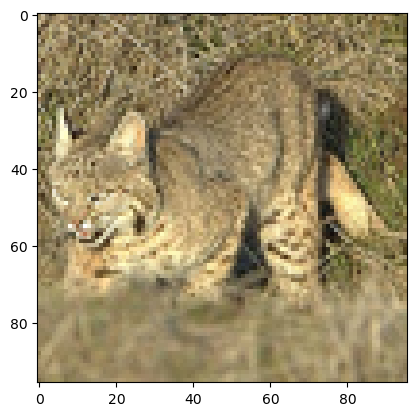

In [4]:
plt.imshow(train_data.data[4].transpose(1,2,0))

In [5]:
batch_size = 32

train_loader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=True,
)

# Build Model
- VIT는 transformer에서 encoder 부분만 사용하는 형태
## 1.Embedding
1. 입력 이미지는 P*P size의 패치로 나눠지고
2. flatten 후 1차원의 백터 형태 변환됨
3. 이후 class token을 추가하고 positional embedding을 추가한 뒤
4. 인코더에 들어감

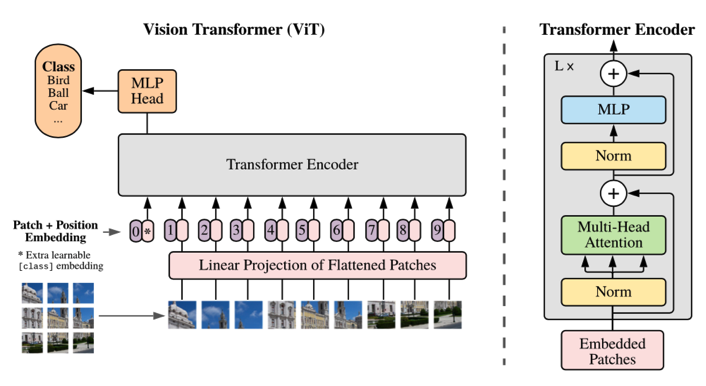

In [6]:
# 가상의 batch, channel, height, width를 만듦
x = torch.randn(8, 3, 224,224)
x.shape

torch.Size([8, 3, 224, 224])

In [7]:
# 1번 케이스, 입력 이미지를 바로 패치화 시키는 경우(채널 + flatten을 한번에)
# batch * c * h * w  => batch * n * p * p * c
# n 은 패치 개수, n = (H*W / (P*P)) => (224 * 224)  / (16 * 16) = 196

patch_size = 16  
print(x.shape)
print(rearrange(x, 'b c (h s1) (w s2) ->  b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size).shape)

torch.Size([8, 3, 224, 224])
torch.Size([8, 196, 768])


In [8]:
# 2번 케이스, 입력 이미지를 convolution 연산을 통해 채널과 가로 세로 변경 후 flatten을 할 경우
patch_size=16
in_channels = 3
emb_size = 768

projection = nn.Sequential(
    # 단순 linear embedding을 하지 않고 convolutional 2D를 이용한 뒤 flatten -> 이를 통해 performance gain을 얻음
    nn.Conv2d(in_channels=in_channels, out_channels=emb_size, kernel_size=patch_size, stride=patch_size), # torch.Size([8, 768, 14, 14])
    Rearrange('b e h w -> b (h w) e')                                                                     # torch.Size([8, 196, 768])
)

projection(x).shape

torch.Size([8, 196, 768])

In [9]:
# cls 토큰과 positional encoding을 추가
img_size = 224
in_channels = 3
patch_size=16
emb_size = 768

# 이미지를 패치화 후 flatten
projected_x = projection(x)
print(f'Projected_x shape : {projected_x.shape}')

# cls_token 정의
# 모델의 파라미터가 될 수 있게끔 Parameter화
# embedding 사이즈와 일치시키기 위해 동일 사이즈 적용
cls_token = nn.Parameter(torch.randn(1,1, emb_size)) 
print(f'cls_token shape : {cls_token.shape}')

# pos encoding 정의
# 모델의 파라미터가 될 수 있게끔 Parameter화
positions = nn.Parameter(torch.randn((img_size//patch_size) ** 2 + 1, emb_size))
print(f'positions shape : {positions.shape}')

# cls token을 배치 사이즈 크기와 일치시켜줌
# repeat 함수 사용
batch_size = 8
cls_tokens = repeat(cls_token, '() n e -> b n e', b=batch_size)
print(f'cls_tokens shape : {cls_tokens.shape}')

print('======='*6)
cat_x = torch.cat([cls_tokens, projected_x], dim=1)
print(f'cat_x shape : {cat_x.shape}')


embedding_x = cat_x + positions
print(f'embedding_x shape : {embedding_x.shape}')

Projected_x shape : torch.Size([8, 196, 768])
cls_token shape : torch.Size([1, 1, 768])
positions shape : torch.Size([197, 768])
cls_tokens shape : torch.Size([8, 1, 768])
cat_x shape : torch.Size([8, 197, 768])
embedding_x shape : torch.Size([8, 197, 768])


### embedding class화

In [10]:
class patch_embedding(nn.Module):
    def __init__(self, img_size:int = 224, in_channels:int=3, patch_size:int= 16, emb_size:int=768):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e h w -> b (h w) e')
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))
        

    def forward(self, x:Tensor) -> Tensor:
        batch_size, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=batch_size)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x

In [11]:
# test
x = patch_embedding()(x)

## 2.MHA(Multi-Head Attention)
1. 동일한 텐서를 Query / Key / Values 로 나누어줌
2. linear projection으로 임베딩된 뒤, 여러개의 head로 나뉘어짐
3. 각각 scaled dot product attention 진행

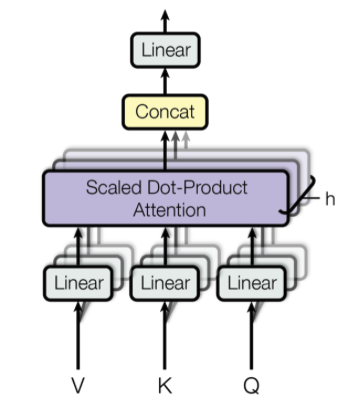

In [12]:
emb_size = 768
num_heads = 8

# QKV 생성, linear projection 진행
# 동일한 임베딩 사이즈를 받아 linear projection하여 동일 사이즈로 보내줌
keys = nn.Linear(emb_size, emb_size)
queries = nn.Linear(emb_size, emb_size)
values  = nn.Linear(emb_size, emb_size)

print(keys)
print(queries)
print(values)

Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=768, bias=True)
Linear(in_features=768, out_features=768, bias=True)


In [13]:
# embedding이 된 x의 shape
print(f'shape of x : {(x).shape}') # torch.Size([8, 197, 768])

# embedding 된 x를 QKV로 만들고, multi-head의 개수만큼 나누어줌
# [배치사이즈, 헤드 개수, 패치길이+1, 임베딩차원/헤드개수]의 형태로 변하게 됨 -> torch.Size([8, 8, 197, 96])
queries = rearrange(queries(x), 'b n (h d) -> b h n d', h=num_heads) # torch.Size([8, 8, 197, 96])
print(f'shape if queries : {queries.shape}')

keys = rearrange(keys(x), 'b n (h d) -> b h n d', h=num_heads)
print(f'shape if queries : {keys.shape}')

values = rearrange(values(x), 'b n (h d) -> b h n d', h=num_heads)
print(f'shape if queries : {values.shape}')

shape of x : torch.Size([8, 197, 768])
shape if queries : torch.Size([8, 8, 197, 96])
shape if queries : torch.Size([8, 8, 197, 96])
shape if queries : torch.Size([8, 8, 197, 96])


### scaled dot product attention, 어텐션 계산

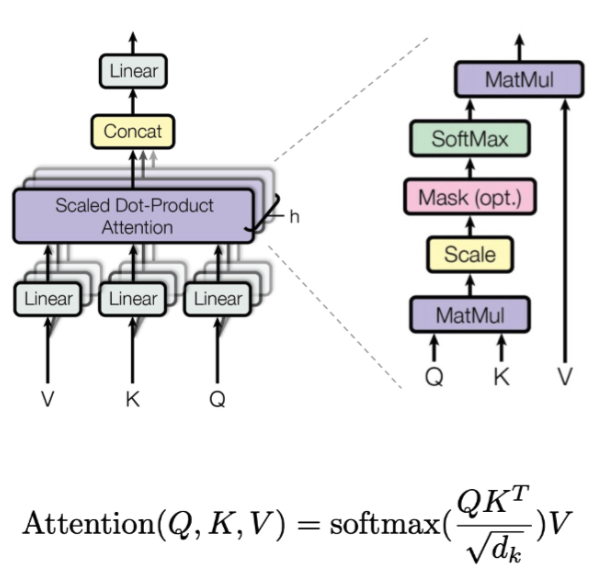

In [14]:
# scaled dot 연산은 torch에서 einsum으로 구현됨(einstein summation)
# 쿼리 키 곱하기, Q*k^T, (197*96) * (96*197)
# [batch_size, num_heads, query length, key length]
energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
print(f'energy : {energy.shape}')

# attention score 구하기
scaling = emb_size ** 0.5
att = F.softmax(energy, dim=-1) # QK 값 기준으로 softmax
att = att / scaling # scaling 으로 나눠주기
print(f'att : {att.shape}')

# attention score * values
# (197*197) * (197*96) = (197*96)
# [batch_size, num_heads, query length, embedding]
out = torch.einsum('bhad, bhdv -> bhav', att, values)
print(f'out : {out.shape}')

# 이후 embedding size로 다시금 만들어줌
# QKV 를 만드는 과정에서 'b n (h d) -> b h n d'를 해줬었음
# 역으로 'b h n d -> b n (h d)'를 진행해서 원상복구
# [batch size, num_heads, attention_score, values
out = rearrange(out, 'b h a v -> b a (h v)')
print(f'out : {out.shape}')

energy : torch.Size([8, 8, 197, 197])
att : torch.Size([8, 8, 197, 197])
out : torch.Size([8, 8, 197, 96])
out : torch.Size([8, 197, 768])


### MHA class화

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size:int =768, num_heads:int = 8, dropout:float=0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads

        self.qkv = nn.Linear(emb_size, emb_size*3) # 앞서 qkv를 따로따로 만든 과정을 하나의 linear에서 나누기 위함
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x, mask:Tensor=None):
        # lineaer 이후 multi-head 를 통과하면서 재정렬 되는 부분까지 한번에 처리
        qkv = rearrange(self.qkv(x), 'b n (h d qkv) -> (qkv) b h n d', h=num_heads, qkv=3)

        queries, keys, values = qkv[0], qkv[1], qkv[2]

        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)

        if mask is not None: # Attention시 무시하고 싶은 부위에 masking
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** 0.5
        att = F.softmax(energy, dim=-1) # QK 값 기준으로 softmax
        att = att / scaling # scaling 으로 나눠주기
        att = self.att_drop(att)

        out = torch.einsum('bhad, bhdv -> bhav', att, values)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.projection(out)
        return out

In [16]:
# test
x = torch.randn(8, 3, 224,224)
patches_embedded = patch_embedding()(x)
MultiHeadAttention()(patches_embedded).shape
    

torch.Size([8, 197, 768])

# 3. Residual Block

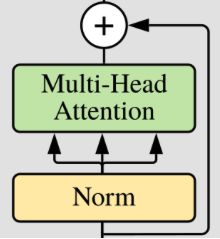

In [17]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs): # 인자를 몇개 받을지 모르니 kwargs 사용
        res = x 
        x = self.fn(x, **kwargs) # 앞서 들어온 함수를 전부 받음
        x += res # skip connection
        return x

# 4. MLP

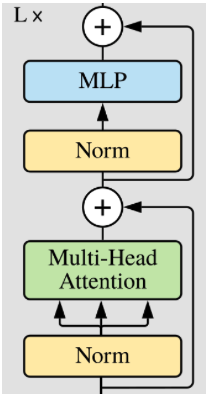

In [18]:
class MLP(nn.Sequential): # Sequential 모듈을 상속받음을 통해 forward 메소드를 별도로 구현할 필요가 없게 만듦
    def __init__(self, emb_size:int=768, expansion:int=4, drop_p:float=0):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size)
        )

# 5.Transformer Encoder Block(하나로 합치기)

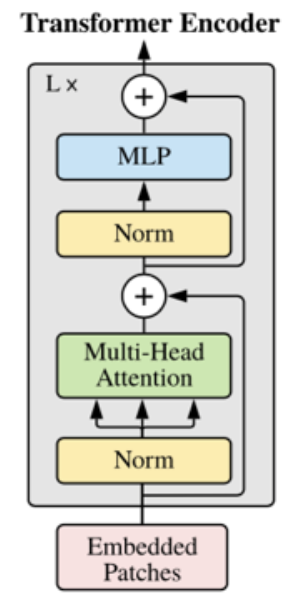

In [19]:
class TransformerEncoderBlock(nn.Sequential): # forward 없이 구현하기 위해 Sequential 사용
    def __init__(self, 
                 emb_size:int = 768,
                 drop_p:float = 0,
                 mlp_expansion:int=4,
                 mlp_drop_p: float=0,
                 **kwargs)-> None:
        super().__init__(
            # encoder 앞단, skip connection + (norm + MHA + dropout)
            ResidualAdd(nn.Sequential( 
                nn.LayerNorm(emb_size), # Norm
                MultiHeadAttention(emb_size, **kwargs), # Multi-Head Attention,
                nn.Dropout(drop_p)  
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size), # Norm
                MLP(emb_size, mlp_expansion, mlp_drop_p),
                nn.Dropout(drop_p)
            ))
        )            

In [20]:
# test
x = torch.randn(8, 3, 224,224)
patches_embedded = patch_embedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([8, 197, 768])

# 6. TransformerBlock 적층하기

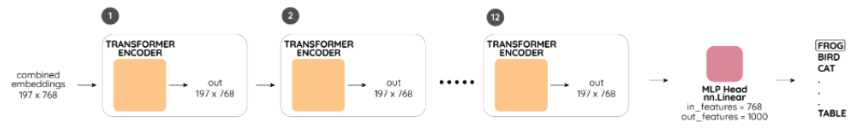

In [21]:
class TransformerEncoder(nn.Sequential):  # forward 없이 구현하기 위해 Sequential 사용
    def __init__(self, depth:int=12, **kwargs):
        # Encoder block이 depth 개수만큼 적층된 구조 
        # list comprehension 밖에 *이 붙음으로 인해 *arg 구조가 되기 때문에 각각의 인코더가 차례대로 쌓이게 됨
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [22]:
# test
x = torch.randn(8, 3, 224,224)
patches_embedded = patch_embedding()(x)
TransformerEncoder()(patches_embedded).shape

torch.Size([8, 197, 768])

# 7. Head 붙이기

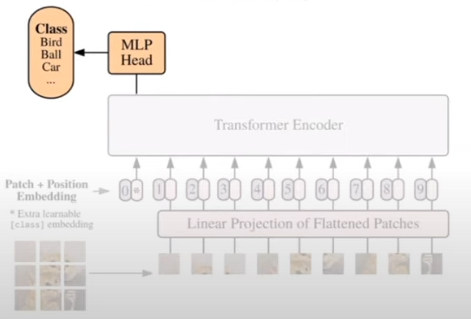

In [23]:
# 원래는 CLS 토큰만 사용하면 됨(CLS 토큰이 전체 이미지를 represent한다고 보기 때문)

# 만약 전체 토큰을 다 사용하고자 할 경우엔 각 토큰을 평균해준 뒤 구하면 가능
# 1. emb_size의 1차원 벡터로 변환시킨 뒤(평균)
# 2. LayerNorm과
# 3. Linear가 붙는 구조

class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size:int=768, n_classes:int= 10):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

# 8. 하나의 모델로 만들기

In [24]:
class VIT(nn.Sequential):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 emb_size:int=768,
                 depth:int=12,
                 n_classes:int=1000,
                 **kwargs):
        super().__init__(
            patch_embedding(img_size=img_size, in_channels=in_channels, patch_size=patch_size, emb_size=emb_size),
            TransformerEncoder(depth=depth, **kwargs),
            ClassificationHead(emb_size=emb_size, n_classes=n_classes)
        )

# 모델 완성!

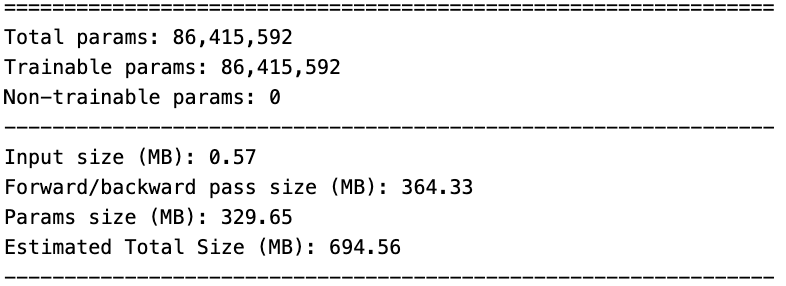

In [25]:
from torchsummary import summary

summary(VIT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
   patch_embedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19

# 모델 학습

In [26]:
model = VIT()

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

model.to(device)

Using cuda device


VIT(
  (0): patch_embedding(
    (projection): Sequential(
      (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (1): Rearrange('b e h w -> b (h w) e')
    )
  )
  (1): TransformerEncoder(
    (0): TransformerEncoderBlock(
      (0): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (att_drop): Dropout(p=0, inplace=False)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (2): Dropout(p=0, inplace=False)
        )
      )
      (1): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (1): MLP(
            (mlp): Sequential(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU(approximate=none)
              (2): Dropout(p=0, inplace=Fals

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-5)

criterion.to(device=device)
model.to(device=device)

VIT(
  (0): patch_embedding(
    (projection): Sequential(
      (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (1): Rearrange('b e h w -> b (h w) e')
    )
  )
  (1): TransformerEncoder(
    (0): TransformerEncoderBlock(
      (0): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (att_drop): Dropout(p=0, inplace=False)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (2): Dropout(p=0, inplace=False)
        )
      )
      (1): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (1): MLP(
            (mlp): Sequential(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU(approximate=none)
              (2): Dropout(p=0, inplace=Fals

In [29]:
# 학습
num_epochs = 20 # 에폭 설정

loss_arr = []
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):  
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        #Forward pass
        output = model(images) # 모델 예측 시행
    
        # 예측에 따른 손실 계산 및 출력
        loss = criterion(output, labels)  

        # backward pass 
        optimizer.zero_grad() # 가중치 변화를 0으로 만들고
        loss.backward() # 역전파를 수행하고
        optimizer.step() # 가중치를 갱신

        running_loss += loss.item()
        loss_arr.append(loss.item())
        # 100번에 한번씩 loss 출력
        if i % 39 == 38: 
            print(f'Training epoch : {epoch+1}, [{i * len(images)} / {len(train_loader.dataset)}] ({100 * i / len(train_loader):0.0f}%), Loss : {running_loss/39:0.6f}')
            running_loss = 0.0

print('학습종료!')

Training epoch : 1, [1216 / 5000] (24%), Loss : 2.732515
Training epoch : 1, [2464 / 5000] (49%), Loss : 2.387779
Training epoch : 1, [3712 / 5000] (74%), Loss : 2.389977
Training epoch : 1, [4960 / 5000] (99%), Loss : 2.306190
Training epoch : 2, [1216 / 5000] (24%), Loss : 2.262903
Training epoch : 2, [2464 / 5000] (49%), Loss : 2.191008
Training epoch : 2, [3712 / 5000] (74%), Loss : 2.115148
Training epoch : 2, [4960 / 5000] (99%), Loss : 2.080695
Training epoch : 3, [1216 / 5000] (24%), Loss : 2.086559
Training epoch : 3, [2464 / 5000] (49%), Loss : 2.040395
Training epoch : 3, [3712 / 5000] (74%), Loss : 2.003855
Training epoch : 3, [4960 / 5000] (99%), Loss : 1.971497
Training epoch : 4, [1216 / 5000] (24%), Loss : 2.016562
Training epoch : 4, [2464 / 5000] (49%), Loss : 1.924571
Training epoch : 4, [3712 / 5000] (74%), Loss : 1.918671
Training epoch : 4, [4960 / 5000] (99%), Loss : 1.911477
Training epoch : 5, [1216 / 5000] (24%), Loss : 1.944413
Training epoch : 5, [2464 / 500

In [30]:
# test 
model.eval() # drop out 같은 학습에만 필요하고 test에는 불필요한 층을 비활성화

# 클래스 개수대로 정답 개수, 총 개수 구하기
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


with torch.no_grad(): # gradient 연산을 멈춘 상태로 계산, 메모리 절약 및 연산속도 증가
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # 결과 예측
        outputs = model(images) # 모델 실행

        # 이미지가 가질 수 있는 라벨 중 가장 높은 확률과 인덱스(라벨)를 출력
        _, predicted = torch.max(outputs.data, dim=1) 

        # 라벨과 정답이 일치하는지 확인
        c = (predicted == labels).squeeze()

        # 한번에 배치 사이즈만큼 예측하기 때문에 batch_size 개수만큼 예측 결과가 나옴
        for i in range(len(data)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [33]:
classes = train_data.classes

In [34]:
# test 결과 확인
total_correct = 0
total = 0

for i in range(10):
    total_correct += class_correct[i]
    total += class_total[i]
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

print(f'Total accuracy : {100 * total_correct/total:0.2f}%')

Accuracy of airplane : 62 %
Accuracy of  bird : 34 %
Accuracy of   car : 56 %
Accuracy of   cat : 11 %
Accuracy of  deer : 35 %
Accuracy of   dog :  0 %
Accuracy of horse : 61 %
Accuracy of monkey :  4 %
Accuracy of  ship : 47 %
Accuracy of truck : 52 %
Total accuracy : 37.40%
